# Stack and Test Models

In [47]:
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
import math
import matplotlib
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

plt.style.use('ggplot')

We load the test set

In [21]:
# Load the test set
df = pd.read_csv('./data/new_test.csv')
df.drop(['Unnamed: 0', 'Id'], axis=1, inplace=True)

# Load categorical variables
numerical = pickle.load(open('./tmp/numerical.list', 'rb'))

df.shape

(1459, 278)

Transform skewed features

In [22]:
# Load list of skewed features
sk_feat = pickle.load(open('./tmp/sk_feat.list', 'rb'))

# Apply Log+1 transformation
df[sk_feat] = np.log1p(df[sk_feat])

Create one hot variables

In [23]:
X=df.copy()

## Predictions using linear models

Load models

In [24]:
models_comb = pickle.load(open('./tmp/models_comb', 'rb'))
models_comb

,model,score
0,model1a,0.041812
1,model1b,0.040537
2,model2a,0.054066
3,model2b,0.054065
4,model3,0.072540


### All variables

Linear regression with ridge regularization

In [25]:
model1a = pickle.load(open('./tmp/model1a.model', 'rb'))
model1a

Ridge(alpha=array([7.9]), copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [26]:
a1 = np.exp(model1a.predict(X))
a1.shape

(1459,)

Linear regression with LASSO regularization

In [27]:
model1b = pickle.load(open('./tmp/model1b.model', 'rb'))
model1b

Lasso(alpha=0.00015000000000000001, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [28]:
b1 = np.exp(model1b.predict(X))
b1.shape

(1459,)

### Selected variables

Load selected variables

In [29]:
selected = pickle.load(open('./tmp/feaure_list_dt.list', 'rb'))
selected

['OverallQual',
 'GrLivArea',
 'CentralAir_Y',
 'TotalBsmtSF',
 'GarageCars',
 'KitchenAbvGr',
 '1stFlrSF',
 'BsmtFinSF1',
 'MSZoning_RM',
 '2ndFlrSF',
 'OverallCond',
 'GarageArea',
 'YearBuilt',
 'LotArea',
 'YearRemodAdd',
 'Neighborhood_Sawyer',
 'BsmtUnfSF',
 'MoSold',
 'PavedDrive_Y',
 'TotRmsAbvGrd',
 'GarageQual_TA',
 'LotFrontage',
 'OpenPorchSF']

In [30]:
X_sel = X[selected]
X_sel.shape

(1459, 23)

Linear regression with ridge regularization

In [31]:
model2a = pickle.load(open('./tmp/model2a.model', 'rb'))
model2a

Ridge(alpha=array([0.8]), copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [32]:
a2 = np.exp(model2a.predict(X_sel))
a2.shape

(1459,)

Linear regression with LASSO regularization

In [33]:
model2b = pickle.load(open('./tmp/model2b.model', 'rb'))
model2b

Lasso(alpha=0.00015000000000000001, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [35]:
b2 = np.exp(model2b.predict(X_sel))
b2.shape

(1459,)

## PCA

In [36]:
pca = decomposition.PCA(n_components=18)
pca.fit(X)
transformed = pca.transform(X)

explained_variance = np.var(transformed, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)

# Find how may components explain 98% of variance
expl = np.cumsum(explained_variance_ratio)
expl


array([0.50900831, 0.79470449, 0.93168189, 0.96624594, 0.99612144,
       0.99840184, 0.99961998, 0.99993355, 0.99994921, 0.9999596 ,
       0.99996841, 0.99997657, 0.99998286, 0.99998785, 0.99999166,
       0.99999485, 0.99999765, 1.        ])

In [37]:
model3 = pickle.load(open('./tmp/model3.model', 'rb'))
model3

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [38]:
m3 = np.exp(model3.predict(transformed))
m3.shape

(1459,)

## TreeRegressor

In [39]:
tree = pickle.load(open('./tmp/tree.model', 'rb'))
tree

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=2,
           min_samples_split=43, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

In [40]:
tr = np.exp(tree.predict(X))
tr.shape

(1459,)

## XGB

In [41]:
xgb_mod = pickle.load(open('./tmp/xgb_mod.model', 'rb'))
xgb_mod

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=nan, n_estimators=60,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [42]:
gb = np.exp(xgb_mod.predict(X))
gb.shape

(1459,)

## Combining 

Let's comnine all predictions

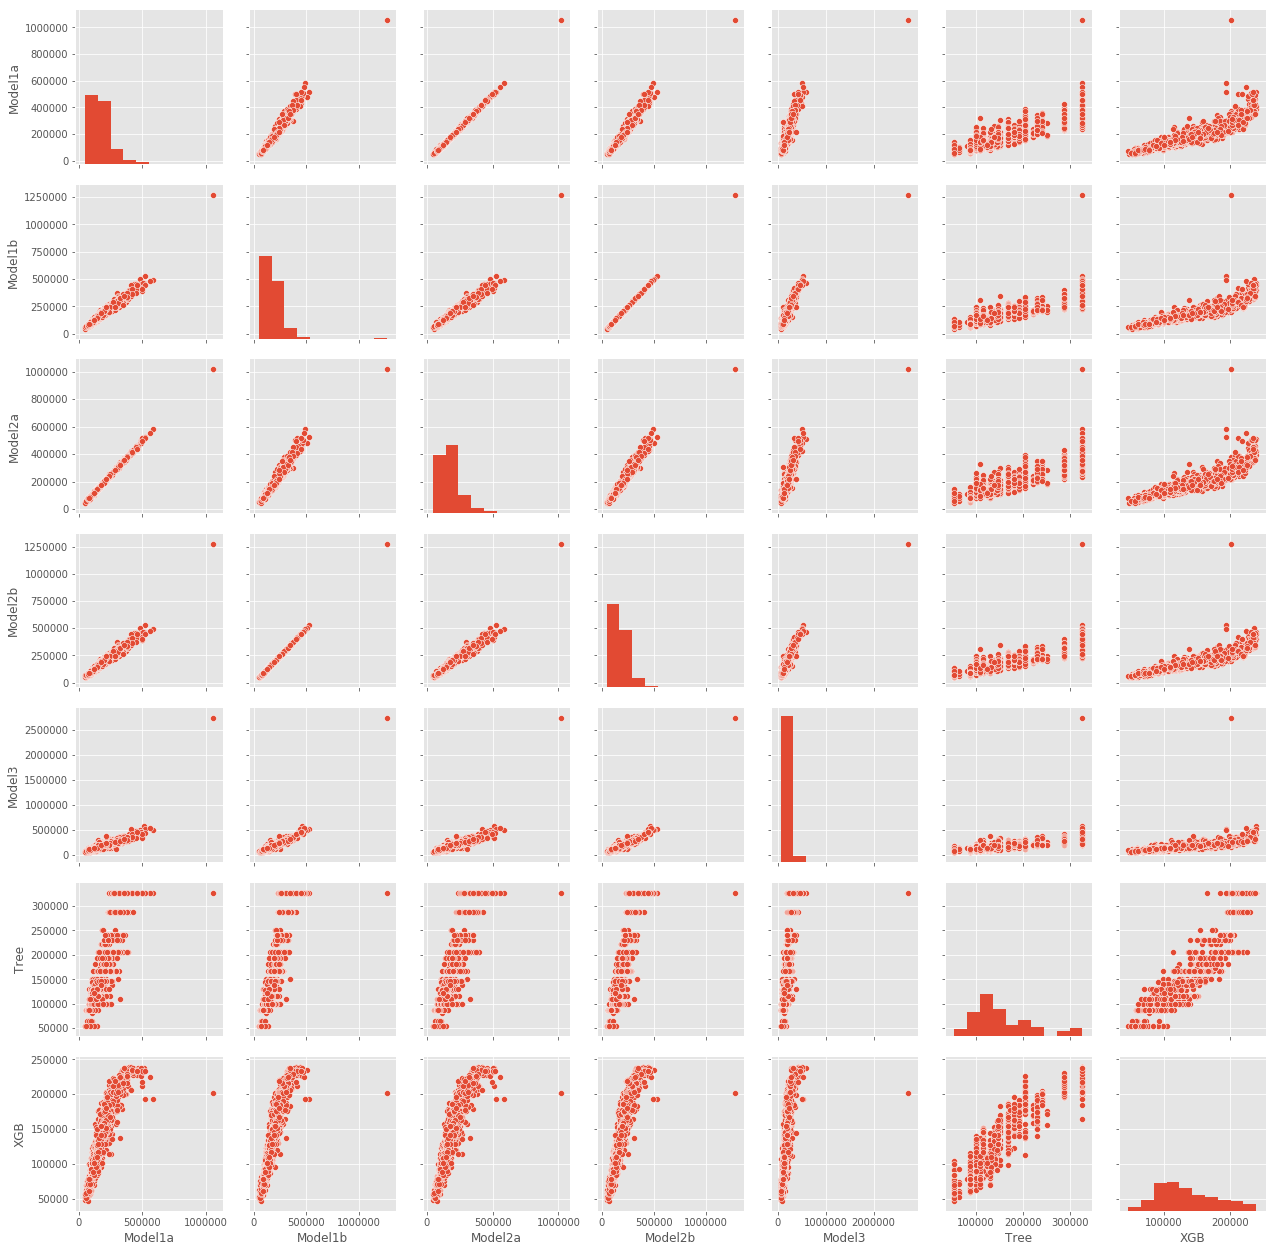

In [49]:
predictions = pd.DataFrame([a1, a2, b1, b2, m3, tr, gb]).T
predictions.columns = ['Model1a', 'Model1b', 'Model2a', 'Model2b', 'Model3', 'Tree', 'XGB']
sns.pairplot(predictions)

Weighting the predictions.

In [119]:
#Load all models results
tree_comb = pickle.load(open('./tmp/tree_comb', 'rb'))

models = models_comb.append(tree_comb).reset_index().drop('index', axis=1)
models

#Calculate weights
sm = np.sum(1/models['score'])
models['wght'] = models.score.apply(lambda x: (1/x) / sm) 

# Apply weights to predictions
weights = np.array(models['wght']).T
pred_mat = np.matrix(predictions)

prediction = weights.dot(pred_mat.T)
prediction.shape

(1, 1459)

In [125]:
prediction = np.ndarray.flatten(prediction.T)
prediction.shape

(1459,)

In [129]:
# Create a dataframe

# Load the test set
df = pd.read_csv('./data/new_test.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)

#Reshape prediction

submission = pd.DataFrame({'Id':df['Id'], 'Predicted': prediction})

submission.head()


,Id,Predicted
0,1461,119249.045899
1,1462,152386.501762
2,1463,176318.578723
3,1464,187885.071689
4,1465,193527.285783


## Use real data

We find the answer key in R package https://cran.r-project.org/web/packages/AmesHousing/index.html

In [128]:
# Load answer key
answer = pd.read_csv('./data/answerkey.csv', index_col=0)
answer.head()

,Id,SalePrice
0,1461,105000
1,1462,172000
2,1463,189900
3,1464,195500
4,1465,191500


In [132]:
# Merge with prediction

result = pd.merge(answer, submission, on='Id', how='left')
result.head()

,Id,SalePrice,Predicted
0,1461,105000,119249.045899
1,1462,172000,152386.501762
2,1463,189900,176318.578723
3,1464,195500,187885.071689
4,1465,191500,193527.285783


We greaphically analyze our predictions

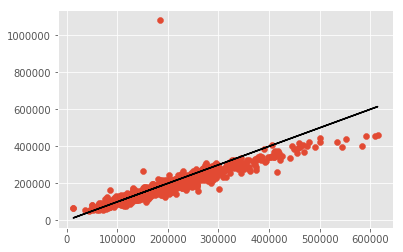

In [135]:
#Plot 

plt.scatter(result['SalePrice'],result['Predicted'])
plt.plot(result['SalePrice'], result['SalePrice'], c='black')

We calculate RMSLE using natural logarithm of prices

In [137]:
rmsle = np.sqrt(np.sum(np.mean((np.log(result['SalePrice']) - np.log(result['Predicted']))**2)))
rmsle

0.14583034894890365

... and the logarithm with base 10.

In [138]:
rmsle10 = np.sqrt(np.sum(np.mean((np.log10(result['SalePrice']) - np.log10(result['Predicted']))**2)))
rmsle10

0.06333331584253458